#####    
학번: 2021136138   
이름: 추승연

# [문제 3]    
데이터 Feature	추가 후 성능 변화 확인하기

## 데이터 변경 코드

In [1]:
import pandas as pd
import sys
import os

# BASE_PATH 설정
BASE_PATH = "/home/work/dl_choo"
btc_krw_path = os.path.join(BASE_PATH, "BTC_KRW.csv")
new_btc_krw_path = os.path.join(BASE_PATH, "new_BTC_KRW.csv")

# 파일 존재 여부 확인
if not os.path.exists(btc_krw_path):
    raise FileNotFoundError(f"File not found: {btc_krw_path}")

# csv 파일 읽기
df = pd.read_csv(btc_krw_path)

# 다음 날의 Open 값을 계산
df["Next_Open"] = df["Open"].shift(-1)

# 새로운 csv 파일 저장
df.to_csv(new_btc_krw_path, index=False)

print(f"New CSV file saved to: {new_btc_krw_path}")


New CSV file saved to: /home/work/dl_choo/new_BTC_KRW.csv


## 기본 코드

##### wandb

In [2]:
# 설치
!pip install --upgrade wandb -qq

In [3]:
# 로그인

import wandb
wandb.login()

# dd1a71254912766fadfb6a33f9321247d90d0148

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: choo0412 (choo0412-korea-university-of-technology-and-education). Use `wandb login --relogin` to force relogin


True

##### import

In [4]:
from datetime import datetime
import os
from pathlib import Path
import sys
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision import datasets, transforms
import wandb
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd

# Set BASE_PATH
BASE_PATH = "/home/work/dl_choo"  # 데이터 파일이 저장된 경로
print(BASE_PATH)
sys.path.append(BASE_PATH)

# Set CHECKPOINT_FILE_PATH
CURRENT_FILE_PATH = BASE_PATH  # 현재 작업 경로를 BASE_PATH로 설정
CHECKPOINT_FILE_PATH = os.path.join(CURRENT_FILE_PATH, "checkpoints")
if not os.path.isdir(CHECKPOINT_FILE_PATH):
    os.makedirs(CHECKPOINT_FILE_PATH)


/home/work/dl_choo


##### utils

In [5]:
# _01_code/_99_common_utils/utils.py

import os
import sys


def is_linux():
    if sys.platform.startswith("linux"):
        return True
    else:
        return False


def is_windows():
    if os.name == "nt":
        return True
    else:
        return False


def is_mac():
    if sys.platform == "darwin":
        return True
    else:
        return False


def get_num_cpu_cores():
    import multiprocessing
    return multiprocessing.cpu_count()


from string import Template

class DeltaTemplate(Template):
    delimiter = "%"

    def strfdelta(tdelta, fmt):
        d = {"D": tdelta.days}
        d["H"], rem = divmod(tdelta.seconds, 3600)
        d["M"], d["S"] = divmod(rem, 60)
        t = DeltaTemplate(fmt)
        return t.substitute(**d)


def strfdelta(td, fmt):

    # Get the timedelta’s sign and absolute number of seconds.
    sign = "-" if td.days < 0 else "+"
    secs = abs(td).total_seconds()

    # Break the seconds into more readable quantities.
    days, rem = divmod(secs, 86400)  # Seconds per day: 24 * 60 * 60
    hours, rem = divmod(rem, 3600)  # Seconds per hour: 60 * 60
    mins, secs = divmod(rem, 60)

    # Format (as per above answers) and return the result string.
    t = DeltaTemplate(fmt)
    return t.substitute(
        s=sign,
        D="{:d}".format(int(days)),
        H="{:02d}".format(int(hours)),
        M="{:02d}".format(int(mins)),
        S="{:02d}".format(int(secs)),
        )


if __name__ == "__main__":
    if is_linux():
        print("Linux")
    elif is_windows():
        print("Windows")
    elif is_mac():
        print("Mac")
    else:
        print("<unknown>")


Linux


##### get_parser

In [6]:
import argparse


def get_parser():
  parser = argparse.ArgumentParser()

  parser.add_argument(
    "--wandb", action=argparse.BooleanOptionalAction, default=False, help="True or False"
  )

  parser.add_argument(
    "-b", "--batch_size", type=int, default=2048, help="Batch size (int, default: 2_048)"
  )

  parser.add_argument(
    "-e", "--epochs", type=int, default=10_000, help="Number of training epochs (int, default:10_000)"
  )

  parser.add_argument(
    "-r", "--learning_rate", type=float, default=1e-4, help="Learning rate (float, default: 1e-3)"
  )

  parser.add_argument(
    "-w", "--weight_decay", type=float, default=0.0, help="Weight decay (float, default: 0.0)"
  )

  parser.add_argument(
    "-v", "--validation_intervals", type=int, default=30,
    help="Number of training epochs between validations (int, default: 10)"
  )

  parser.add_argument(
    "-p", "--early_stop_patience", type=int, default=30,
    help="Number of early stop patience (int, default: 10)"
  )

  parser.add_argument(
    "-d", "--early_stop_delta", type=float, default=0.000001,
    help="Delta value of early stop (float, default: 0.000001)"
  )

  return parser


##### class EarlyStopping

In [7]:
class EarlyStopping:
  """Early stops the training if validation loss doesn't improve after a given patience."""
  def __init__(self, patience=10, delta=0.00001, project_name=None, checkpoint_file_path=None, run_time_str=None):
    self.patience = patience
    self.counter = 0
    self.delta = delta

    self.val_loss_min = None
    self.file_path = os.path.join(
      checkpoint_file_path, f"{project_name}_checkpoint_{run_time_str}.pt"
    )
    self.latest_file_path = os.path.join(
      checkpoint_file_path, f"{project_name}_checkpoint_latest.pt"
    )

  def check_and_save(self, new_validation_loss, model):
    early_stop = False

    if self.val_loss_min is None:
      self.val_loss_min = new_validation_loss
      message = f'Early stopping is stated!'
    elif new_validation_loss < self.val_loss_min - self.delta:
      message = f'V_loss decreased ({self.val_loss_min:7.5f} --> {new_validation_loss:7.5f}). Saving model...'
      self.save_checkpoint(new_validation_loss, model)
      self.val_loss_min = new_validation_loss
      self.counter = 0
    else:
      self.counter += 1
      message = f'Early stopping counter: {self.counter} out of {self.patience}'
      if self.counter >= self.patience:
        early_stop = True
        message += " *** TRAIN EARLY STOPPED! ***"

    return message, early_stop

  def save_checkpoint(self, val_loss, model):
    '''Saves model when validation loss decrease.'''
    torch.save(model.state_dict(), self.file_path)
    torch.save(model.state_dict(), self.latest_file_path)
    self.val_loss_min = val_loss




##### class CryptoCurrencyDataset

In [8]:
class CryptoCurrencyDataset(Dataset):
  def __init__(self, X, y, is_regression=True):
    self.X = X
    self.y = y

    assert len(self.X) == len(self.y)

  def __len__(self):
    return len(self.X)

  def __getitem__(self, idx):
    X = self.X[idx]
    y = self.y[idx]
    return X, y

  def __str__(self):
    str = "Data Size: {0}, Input Shape: {1}, Target Shape: {2}".format(
      len(self.X), self.X.shape, self.y.shape
    )
    return str




## 실습 코드

### _01_code/_11_lstm_and_its_application/g_crypto_currency_regression_train_lstm.py

##### get_crytocurrency_data

In [9]:
def get_cryptocurrency_data(
    sequence_size=10, validation_size=100, test_size=10, target_column='Close', y_normalizer=1.0e7, is_regression=True
):
    # 경로 설정
    BASE_PATH = "/home/work/dl_choo"  # 데이터 파일이 저장된 경로
    btc_krw_path = os.path.join(BASE_PATH, "BTC_KRW.csv")  # 파일 경로
    df = pd.read_csv(btc_krw_path)

    row_size = len(df)
    # ['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Next_Open']
    date_list = df['Date']  # Date 열은 삭제되기 전에 사용됩니다.

    df = df.drop(columns=['Date'])  # Date 열 삭제

    data_size = row_size - sequence_size
    train_size = data_size - (validation_size + test_size)
    #################################################################################################

    row_cursor = 0

    X_train_list = []
    y_train_regression_list = []
    y_train_classification_list = []
    y_train_date = []
    for idx in range(0, train_size):
        sequence_data = df.iloc[idx: idx + sequence_size].values  # sequence_data.shape: (sequence_size, 5)
        X_train_list.append(torch.from_numpy(sequence_data))
        y_train_regression_list.append(df.iloc[idx + sequence_size][target_column])
        y_train_classification_list.append(
            1 if df.iloc[idx + sequence_size][target_column] >= df.iloc[idx + sequence_size - 1][target_column] else 0
        )
        y_train_date.append(date_list[idx + sequence_size])
        row_cursor += 1

    X_train = torch.stack(X_train_list, dim=0).to(torch.float)
    y_train_regression = torch.tensor(y_train_regression_list, dtype=torch.float32) / y_normalizer
    y_train_classification = torch.tensor(y_train_classification_list, dtype=torch.int64)

    m = X_train.mean(dim=0, keepdim=True)
    s = X_train.std(dim=0, unbiased=False, keepdim=True)
    X_train = (X_train - m) / s

    #################################################################################################

    X_validation_list = []
    y_validation_regression_list = []
    y_validation_classification_list = []
    y_validation_date = []
    for idx in range(row_cursor, row_cursor + validation_size):
        sequence_data = df.iloc[idx: idx + sequence_size].values  # sequence_data.shape: (sequence_size, 5)
        X_validation_list.append(torch.from_numpy(sequence_data))
        y_validation_regression_list.append(df.iloc[idx + sequence_size][target_column])
        y_validation_classification_list.append(
            1 if df.iloc[idx + sequence_size][target_column] >= df.iloc[idx + sequence_size - 1][target_column] else 0
        )
        y_validation_date.append(date_list[idx + sequence_size])
        row_cursor += 1

    X_validation = torch.stack(X_validation_list, dim=0).to(torch.float)
    y_validation_regression = torch.tensor(y_validation_regression_list, dtype=torch.float32) / y_normalizer
    y_validation_classification = torch.tensor(y_validation_classification_list, dtype=torch.int64)

    X_validation = (X_validation - m) / s
    #################################################################################################

    X_test_list = []
    y_test_regression_list = []
    y_test_classification_list = []
    y_test_date = []
    for idx in range(row_cursor, row_cursor + test_size):
        sequence_data = df.iloc[idx: idx + sequence_size].values  # sequence_data.shape: (sequence_size, 5)
        X_test_list.append(torch.from_numpy(sequence_data))
        y_test_regression_list.append(df.iloc[idx + sequence_size][target_column])
        y_test_classification_list.append(
            1 if df.iloc[idx + sequence_size][target_column] > df.iloc[idx + sequence_size - 1][target_column] else 0
        )
        y_test_date.append(date_list[idx + sequence_size])
        row_cursor += 1

    X_test = torch.stack(X_test_list, dim=0).to(torch.float)
    y_test_regression = torch.tensor(y_test_regression_list, dtype=torch.float32) / y_normalizer
    y_test_classification = torch.tensor(y_test_classification_list, dtype=torch.int64)

    X_test = (X_test - m) / s

    if is_regression:
        return (
            X_train, X_validation, X_test,
            y_train_regression, y_validation_regression, y_test_regression,
            y_train_date, y_validation_date, y_test_date
        )
    else:
        return (
            X_train, X_validation, X_test,
            y_train_classification, y_validation_classification, y_test_classification,
            y_train_date, y_validation_date, y_test_date
        )


##### get_btc_krw_data

In [10]:
def get_btc_krw_data(sequence_size=10, validation_size=100, test_size=10, is_regression=True):
  X_train, X_validation, X_test, y_train, y_validation, y_test, y_train_date, y_validation_date, y_test_date \
    = get_cryptocurrency_data(
      sequence_size=sequence_size, validation_size=validation_size, test_size=test_size,
      target_column='Close', y_normalizer=1.0e7, is_regression=is_regression
  )

  train_crypto_currency_dataset = CryptoCurrencyDataset(X=X_train, y=y_train)
  validation_crypto_currency_dataset = CryptoCurrencyDataset(X=X_validation, y=y_validation)
  test_crypto_currency_dataset = CryptoCurrencyDataset(X=X_test, y=y_test)

  train_data_loader = DataLoader(
    dataset=train_crypto_currency_dataset, batch_size=wandb.config.batch_size, shuffle=True
  )
  validation_data_loader = DataLoader(
    dataset=validation_crypto_currency_dataset, batch_size=wandb.config.batch_size, shuffle=True
  )
  test_data_loader = DataLoader(
    dataset=test_crypto_currency_dataset, batch_size=len(test_crypto_currency_dataset), shuffle=True
  )

  return train_data_loader, validation_data_loader, test_data_loader

##### class RegressionTrainer

In [11]:
class RegressionTrainer:
  def __init__(
    self, project_name, model, optimizer, train_data_loader, validation_data_loader, transforms,
    run_time_str, wandb, device, checkpoint_file_path
  ):
    self.project_name = project_name
    self.model = model
    self.optimizer = optimizer
    self.train_data_loader = train_data_loader
    self.validation_data_loader = validation_data_loader
    self.transforms = transforms
    self.run_time_str = run_time_str
    self.wandb = wandb
    self.device = device
    self.checkpoint_file_path = checkpoint_file_path

    # Use a built-in loss function
    self.loss_fn = nn.MSELoss()

  def do_train(self):
    self.model.train()  # Explained at 'Diverse Techniques' section

    loss_train = 0.0
    num_trains = 0

    for train_batch in self.train_data_loader:
      input_train, target_train = train_batch
      input_train = input_train.to(device=self.device)
      target_train = target_train.to(device=self.device)

      if self.transforms:
        input_train = self.transforms(input_train)

      output_train = self.model(input_train)

      loss = self.loss_fn(output_train.squeeze(dim=-1), target_train)

      loss_train += loss.item()

      num_trains += 1

      self.optimizer.zero_grad()
      loss.backward()
      self.optimizer.step()

    train_loss = loss_train / num_trains

    return train_loss

  def do_validation(self):
    self.model.eval()   # Explained at 'Diverse Techniques' section

    loss_validation = 0.0
    num_validations = 0

    with torch.no_grad():
      for validation_batch in self.validation_data_loader:
        input_validation, target_validation = validation_batch
        input_validation = input_validation.to(device=self.device)
        target_validation = target_validation.to(device=self.device)

        if self.transforms:
          input_validation = self.transforms(input_validation)

        output_validation = self.model(input_validation)

        loss_validation += self.loss_fn(output_validation.squeeze(dim=-1), target_validation).item()

        num_validations += 1

    validation_loss = loss_validation / num_validations

    return validation_loss

  def train_loop(self):
    early_stopping = EarlyStopping(
      patience=self.wandb.config.early_stop_patience,
      delta=self.wandb.config.early_stop_delta,
      project_name=self.project_name,
      checkpoint_file_path=self.checkpoint_file_path,
      run_time_str=self.run_time_str
    )
    n_epochs = self.wandb.config.epochs
    training_start_time = datetime.now()

    for epoch in range(1, n_epochs + 1):
      train_loss = self.do_train()

      if epoch == 1 or epoch % self.wandb.config.validation_intervals == 0:
        validation_loss = self.do_validation()

        elapsed_time = datetime.now() - training_start_time
        epoch_per_second = 1000 * epoch / elapsed_time.microseconds

        message, early_stop = early_stopping.check_and_save(validation_loss, self.model)

        print(
          f"[Epoch {epoch:>3}] "
          f"T_loss: {train_loss:7.5f}, "
          f"V_loss: {validation_loss:7.5f}, "
          f"{message} | "
          f"T_time: {strfdelta(elapsed_time, '%H:%M:%S')}, "
          f"T_speed: {epoch_per_second:4.3f}"
        )

        self.wandb.log({
          "Epoch": epoch,
          "Training loss": train_loss,
          "Validation loss": validation_loss,
          "Training speed (epochs/sec.)": epoch_per_second,
        })

        if early_stop:
          break

    elapsed_time = datetime.now() - training_start_time
    print(f"Final training time: {strfdelta(elapsed_time, '%H:%M:%S')}")


##### get_model

In [12]:
def get_model():
    class MyModel(nn.Module):
        def __init__(self, n_input):
            super().__init__()
            self.lstm = nn.LSTM(input_size=n_input, hidden_size=128, num_layers=2, batch_first=True, dropout=0.0)
            self.fcn = nn.Linear(in_features=128, out_features=1)  # 출력 크기 1로 변경

        def forward(self, x):
            x, _ = self.lstm(x)
            x = x[:, -1, :]  # 마지막 hidden state 사용
            x = self.fcn(x)
            return x

    return MyModel(n_input=5)  # 입력 크기 유지


##### main

In [13]:
def main(args):
  run_time_str = datetime.now().astimezone().strftime('%Y-%m-%d_%H-%M-%S')

  config = {
    'epochs': args.epochs,
    'batch_size': args.batch_size,
    'validation_intervals': args.validation_intervals,
    'learning_rate': args.learning_rate,
    'early_stop_patience': args.early_stop_patience,
    'early_stop_delta': args.early_stop_delta,
    'weight_decay': args.weight_decay
  }

  project_name = "lstm_regression_btc_krw"
  wandb.init(
    mode="online" if args.wandb else "disabled",
    project=project_name,
    notes="btc_krw experiment with lstm",
    tags=["lstm", "regression", "btc_krw"],
    name=run_time_str,
    config=config
  )
  print(args)
  print(wandb.config)

  train_data_loader, validation_data_loader, _ = get_btc_krw_data()
  device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
  print(f"Training on device {device}.")

  model = get_model()
  model.to(device)
  wandb.watch(model)

  optimizer = optim.Adam(model.parameters(), lr=wandb.config.learning_rate, weight_decay=wandb.config.weight_decay)

  regression_trainer = RegressionTrainer(
    project_name, model, optimizer, train_data_loader, validation_data_loader, None,
    run_time_str, wandb, device, CHECKPOINT_FILE_PATH
  )
  regression_trainer.train_loop()

  wandb.finish()

##### run - feature 추가 전

In [20]:
if __name__ == "__main__":
  # 변경3 weight decay (-w)
  args_str = "--wandb -w 0.0001"
  args_list = args_str.split()

  parser = get_parser()
  args = parser.parse_args(args_list)
  main(args)

  # python _01_code/_11_lstm_and_its_application/f_crypto_currency_regression_train_lstm.py --wandb

Namespace(wandb=True, batch_size=2048, epochs=10000, learning_rate=0.0001, weight_decay=0.0001, validation_intervals=30, early_stop_patience=30, early_stop_delta=1e-06)
{'epochs': 10000, 'batch_size': 2048, 'validation_intervals': 30, 'learning_rate': 0.0001, 'early_stop_patience': 30, 'early_stop_delta': 1e-06, 'weight_decay': 0.0001}
Training on device cuda:0.
[Epoch   1] T_loss: 10.82179, V_loss: 82.30225, Early stopping is stated! | T_time: 00:00:00, T_speed: 0.006
[Epoch  30] T_loss: 7.10037, V_loss: 52.30203, V_loss decreased (82.30225 --> 52.30203). Saving model... | T_time: 00:00:01, T_speed: 0.098
[Epoch  60] T_loss: 0.86602, V_loss: 13.36775, V_loss decreased (52.30203 --> 13.36775). Saving model... | T_time: 00:00:02, T_speed: 0.121
[Epoch  90] T_loss: 0.47234, V_loss: 9.40049, V_loss decreased (13.36775 --> 9.40049). Saving model... | T_time: 00:00:03, T_speed: 0.128
[Epoch 120] T_loss: 0.31276, V_loss: 6.68396, V_loss decreased (9.40049 --> 6.68396). Saving model... | T_ti

[Epoch 1740] T_loss: 0.01747, V_loss: 0.64947, V_loss decreased (0.65665 --> 0.64947). Saving model... | T_time: 00:01:09, T_speed: 1.976
[Epoch 1770] T_loss: 0.01704, V_loss: 0.63885, V_loss decreased (0.64947 --> 0.63885). Saving model... | T_time: 00:01:11, T_speed: 25.192
[Epoch 1800] T_loss: 0.01709, V_loss: 0.62982, V_loss decreased (0.63885 --> 0.62982). Saving model... | T_time: 00:01:12, T_speed: 6.974
[Epoch 1830] T_loss: 0.01679, V_loss: 0.62360, V_loss decreased (0.62982 --> 0.62360). Saving model... | T_time: 00:01:13, T_speed: 4.073
[Epoch 1860] T_loss: 0.01655, V_loss: 0.61568, V_loss decreased (0.62360 --> 0.61568). Saving model... | T_time: 00:01:14, T_speed: 2.907
[Epoch 1890] T_loss: 0.01627, V_loss: 0.60647, V_loss decreased (0.61568 --> 0.60647). Saving model... | T_time: 00:01:15, T_speed: 2.301
[Epoch 1920] T_loss: 0.01593, V_loss: 0.59737, V_loss decreased (0.60647 --> 0.59737). Saving model... | T_time: 00:01:17, T_speed: 359.080
[Epoch 1950] T_loss: 0.01609, V

[Epoch 3570] T_loss: 0.01148, V_loss: 0.39905, Early stopping counter: 1 out of 30 | T_time: 00:02:22, T_speed: 5.090
[Epoch 3600] T_loss: 0.01151, V_loss: 0.39719, Early stopping counter: 2 out of 30 | T_time: 00:02:23, T_speed: 4.104
[Epoch 3630] T_loss: 0.01134, V_loss: 0.39537, V_loss decreased (0.39652 --> 0.39537). Saving model... | T_time: 00:02:25, T_speed: 61.646
[Epoch 3660] T_loss: 0.01133, V_loss: 0.39824, Early stopping counter: 1 out of 30 | T_time: 00:02:26, T_speed: 14.624
[Epoch 3690] T_loss: 0.01135, V_loss: 0.39767, Early stopping counter: 2 out of 30 | T_time: 00:02:27, T_speed: 8.660
[Epoch 3720] T_loss: 0.01134, V_loss: 0.39381, V_loss decreased (0.39537 --> 0.39381). Saving model... | T_time: 00:02:28, T_speed: 6.182
[Epoch 3750] T_loss: 0.01136, V_loss: 0.39387, Early stopping counter: 1 out of 30 | T_time: 00:02:29, T_speed: 4.763
[Epoch 3780] T_loss: 0.01135, V_loss: 0.39854, Early stopping counter: 2 out of 30 | T_time: 00:02:30, T_speed: 4.001
[Epoch 3810] T

Epoch,▁▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇███
Training loss,█▆▄▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Training speed (epochs/sec.),▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▂▁▁▁▁▂▁▁▁▁▁▁▁▁█▁▃▁▁▂▁▃▂▂
Validation loss,█▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Epoch,4710
Training loss,0.01093
Training speed (epochs/sec.),40.53391
Validation loss,0.40956


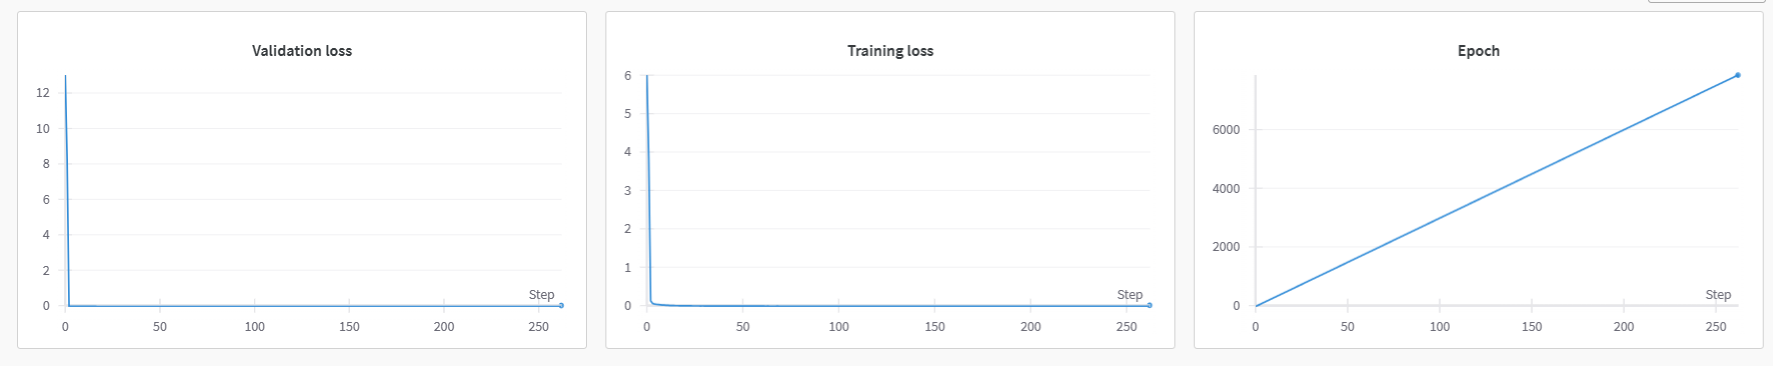

In [ ]:
#![이미지](https://drive.google.com/file/d/1esF9ZTx0CSNI-8AAirwPXfNQWjnyIIYR/view?usp=drive_link)

from IPython.display import Image
BASE_PATH = "/content/drive/MyDrive/DeepLeaning/"
img = os.path.join(BASE_PATH , "11.PNG")
Image(img)

##### run - feature 추가 후

In [21]:
if __name__ == "__main__":
  # 변경3 weight decay (-w)
  args_str = "--wandb -w 0.0001"
  args_list = args_str.split()

  parser = get_parser()
  args = parser.parse_args(args_list)
  main(args)

  # python _01_code/_11_lstm_and_its_application/f_crypto_currency_regression_train_lstm.py --wandb

Namespace(wandb=True, batch_size=2048, epochs=10000, learning_rate=0.0001, weight_decay=0.0001, validation_intervals=30, early_stop_patience=30, early_stop_delta=1e-06)
{'epochs': 10000, 'batch_size': 2048, 'validation_intervals': 30, 'learning_rate': 0.0001, 'early_stop_patience': 30, 'early_stop_delta': 1e-06, 'weight_decay': 0.0001}
Training on device cuda:0.
[Epoch   1] T_loss: 10.68714, V_loss: 80.71466, Early stopping is stated! | T_time: 00:00:00, T_speed: 0.030
[Epoch  30] T_loss: 6.16674, V_loss: 43.99238, V_loss decreased (80.71466 --> 43.99238). Saving model... | T_time: 00:00:01, T_speed: 0.147
[Epoch  60] T_loss: 0.62509, V_loss: 10.04386, V_loss decreased (43.99238 --> 10.04386). Saving model... | T_time: 00:00:02, T_speed: 0.151
[Epoch  90] T_loss: 0.34212, V_loss: 7.00921, V_loss decreased (10.04386 --> 7.00921). Saving model... | T_time: 00:00:03, T_speed: 0.154
[Epoch 120] T_loss: 0.25237, V_loss: 5.19252, V_loss decreased (7.00921 --> 5.19252). Saving model... | T_ti

[Epoch 1740] T_loss: 0.01667, V_loss: 0.57583, V_loss decreased (0.58280 --> 0.57583). Saving model... | T_time: 00:01:08, T_speed: 1.832
[Epoch 1770] T_loss: 0.01672, V_loss: 0.56968, V_loss decreased (0.57583 --> 0.56968). Saving model... | T_time: 00:01:10, T_speed: 13.981
[Epoch 1800] T_loss: 0.01635, V_loss: 0.55913, V_loss decreased (0.56968 --> 0.55913). Saving model... | T_time: 00:01:11, T_speed: 5.597
[Epoch 1830] T_loss: 0.01648, V_loss: 0.55068, V_loss decreased (0.55913 --> 0.55068). Saving model... | T_time: 00:01:12, T_speed: 3.577
[Epoch 1860] T_loss: 0.01632, V_loss: 0.54116, V_loss decreased (0.55068 --> 0.54116). Saving model... | T_time: 00:01:13, T_speed: 2.774
[Epoch 1890] T_loss: 0.01638, V_loss: 0.53278, V_loss decreased (0.54116 --> 0.53278). Saving model... | T_time: 00:01:14, T_speed: 2.219
[Epoch 1920] T_loss: 0.01577, V_loss: 0.52546, V_loss decreased (0.53278 --> 0.52546). Saving model... | T_time: 00:01:16, T_speed: 60.929
[Epoch 1950] T_loss: 0.01573, V_

[Epoch 3600] T_loss: 0.01139, V_loss: 0.35171, Early stopping counter: 4 out of 30 | T_time: 00:02:22, T_speed: 14.617
[Epoch 3630] T_loss: 0.01137, V_loss: 0.34736, V_loss decreased (0.34812 --> 0.34736). Saving model... | T_time: 00:02:23, T_speed: 8.595
[Epoch 3660] T_loss: 0.01125, V_loss: 0.34848, Early stopping counter: 1 out of 30 | T_time: 00:02:24, T_speed: 5.886
[Epoch 3690] T_loss: 0.01138, V_loss: 0.34871, Early stopping counter: 2 out of 30 | T_time: 00:02:25, T_speed: 4.665
[Epoch 3720] T_loss: 0.01123, V_loss: 0.34849, Early stopping counter: 3 out of 30 | T_time: 00:02:26, T_speed: 3.847
[Epoch 3750] T_loss: 0.01142, V_loss: 0.35082, Early stopping counter: 4 out of 30 | T_time: 00:02:28, T_speed: 29.298
[Epoch 3780] T_loss: 0.01138, V_loss: 0.35314, Early stopping counter: 5 out of 30 | T_time: 00:02:29, T_speed: 13.197
[Epoch 3810] T_loss: 0.01125, V_loss: 0.34857, Early stopping counter: 6 out of 30 | T_time: 00:02:30, T_speed: 8.481
[Epoch 3840] T_loss: 0.01112, V_l

Epoch,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
Training loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Training speed (epochs/sec.),▁▁▁▁▁▁▂▁▁▁▅▁▁▁▁▂▂▂▁▁▃█▂▁▁▁▂▂▂▁▂▃▁▄▂▂▂▁▄▁
Validation loss,█▆▅▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Epoch,4530
Training loss,0.01104
Training speed (epochs/sec.),32.23557
Validation loss,0.3536


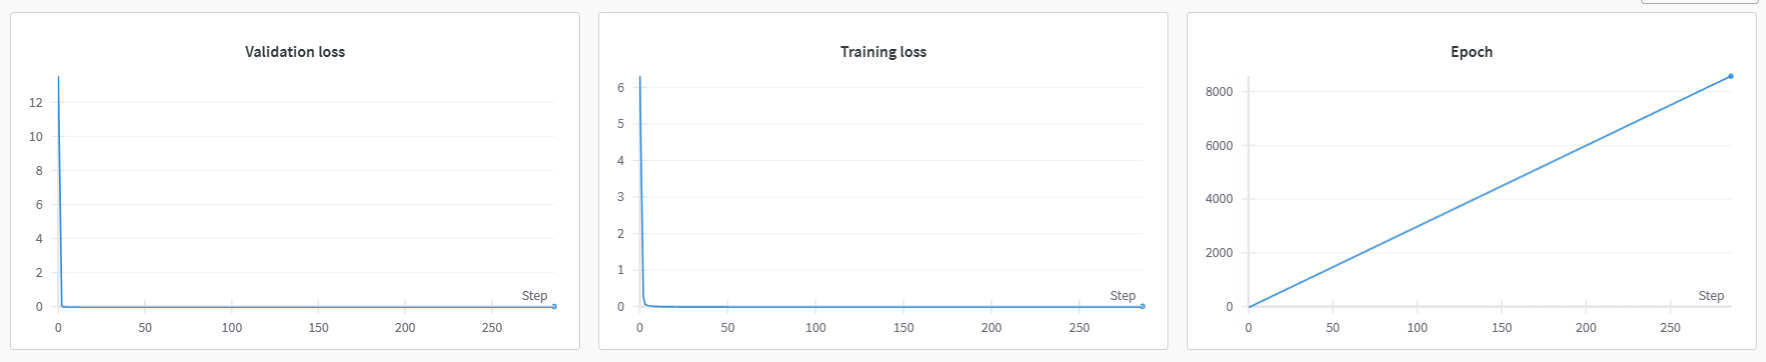

In [ ]:
#![이미지](https://drive.google.com/file/d/1esF9ZTx0CSNI-8AAirwPXfNQWjnyIIYR/view?usp=drive_link)

from IPython.display import Image
BASE_PATH = "/content/drive/MyDrive/DeepLeaning/"
img = os.path.join(BASE_PATH , "12.PNG")
Image(img)

### _01_code/_11_lstm_and_its_application/h_crypto_currency_regression_test_lstm.py

##### test

In [14]:
def test(test_model):
  _, _, test_data_loader = get_btc_krw_data()

  test_model.eval()

  y_normalizer = 100

  print("[TEST DATA]")
  with torch.no_grad():
    for test_batch in test_data_loader:
      input_test, target_test = test_batch

      output_test = test_model(input_test)

    for idx, (output, target) in enumerate(zip(output_test, target_test)):
      print("{0:2}: {1:6,.2f} <--> {2:6,.2f} (Loss: {3:>13,.2f})".format(
        idx,
        output.item() * y_normalizer,
        target.item() * y_normalizer,
        abs(output.squeeze(dim=-1).item() - target.item()) * y_normalizer
      ))

##### predict_all

In [15]:
def predict_all(test_model):
  y_normalizer = 100

  X_train, X_validation, X_test, y_train, y_validation, y_test, y_train_date, y_validation_date, y_test_date \
    = get_cryptocurrency_data(
      sequence_size=10, validation_size=100, test_size=10,
      target_column='Close', y_normalizer=1.0e7, is_regression=True
  )

  train_crypto_currency_dataset = CryptoCurrencyDataset(X=X_train, y=y_train)
  validation_crypto_currency_dataset = CryptoCurrencyDataset(X=X_validation, y=y_validation)
  test_crypto_currency_dataset = CryptoCurrencyDataset(X=X_test, y=y_test)

  dataset_list = [
    train_crypto_currency_dataset, validation_crypto_currency_dataset, test_crypto_currency_dataset
  ]
  dataset_labels = [
    "train", "validation", "test"
  ]
  num = 0
  fig, axs = plt.subplots(3, 1, figsize=(6, 9))

  for i in range(3):
    X = []
    TARGET_Y = []
    PREDICTION_Y = []
    for data in dataset_list[i]:
      input, target = data
      prediction = test_model(input.unsqueeze(0)).squeeze(-1).squeeze(-1)

      X.append(num)
      TARGET_Y.append(target.item() * y_normalizer)
      PREDICTION_Y.append(prediction.item() * y_normalizer)

      num += 1

    axs[i].plot(X, TARGET_Y, label='target')
    axs[i].plot(X, PREDICTION_Y, label='prediction')
    axs[i].set_title(dataset_labels[i])
    axs[i].legend()

  plt.tight_layout()
  plt.show()

##### main

In [16]:
def main(args):
  run_time_str = datetime.now().astimezone().strftime('%Y-%m-%d_%H-%M-%S')

  config = {
    'epochs': args.epochs,
    'batch_size': args.batch_size,
    'validation_intervals': args.validation_intervals,
    'learning_rate': args.learning_rate,
    'early_stop_patience': args.early_stop_patience,
    'early_stop_delta': args.early_stop_delta,
  }

  project_name = "lstm_regression_btc_krw"
  wandb.init(
    mode="disabled",
    project=project_name,
    notes="btc_krw experiment with lstm",
    tags=["lstm", "regression", "btc_krw"],
    name=run_time_str,
    config=config
  )

  test_model = get_model()

  project_name = "lstm_regression_btc_krw"
  latest_file_path = os.path.join(
    CHECKPOINT_FILE_PATH, f"{project_name}_checkpoint_latest.pt"
  )
  print("MODEL FILE: {0}".format(latest_file_path))
  test_model.load_state_dict(torch.load(latest_file_path, map_location=torch.device('cpu')))

  test(test_model)
  predict_all(test_model)


##### run - feature 추가 전

MODEL FILE: /content/checkpoints/lstm_regression_btc_krw_checkpoint_latest.pt
[TEST DATA]
 0: 464.29 <--> 459.89 (Loss:          4.40)
 1: 446.78 <--> 455.68 (Loss:          8.90)
 2: 401.62 <--> 404.00 (Loss:          2.38)
 3: 460.34 <--> 468.41 (Loss:          8.07)
 4: 458.66 <--> 462.33 (Loss:          3.67)
 5: 404.22 <--> 405.02 (Loss:          0.80)
 6: 458.55 <--> 466.85 (Loss:          8.29)
 7: 471.12 <--> 461.57 (Loss:          9.55)
 8: 464.56 <--> 464.58 (Loss:          0.02)
 9: 404.55 <--> 444.08 (Loss:         39.53)


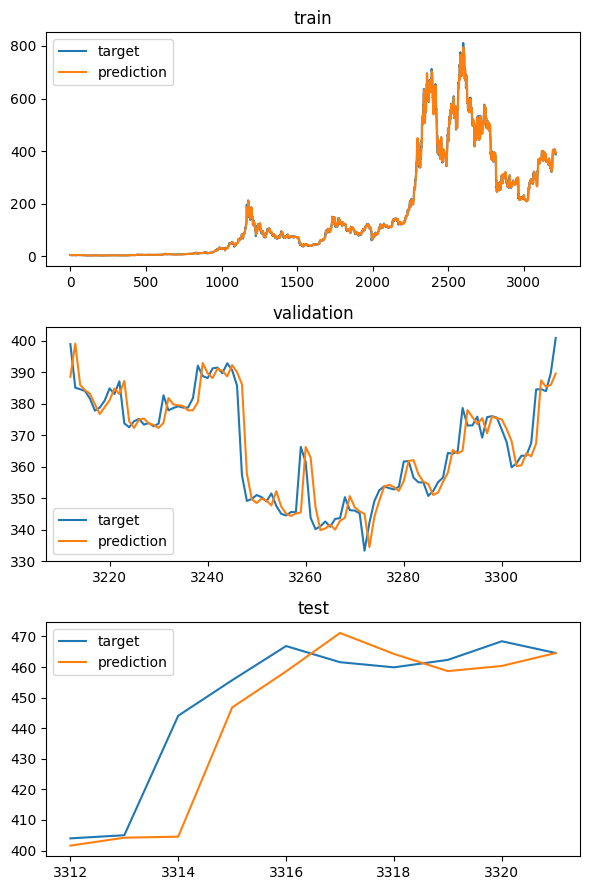

In [ ]:
if __name__ == "__main__":
  args_str = ""
  args_list = args_str.split()

  parser = get_parser()
  args = parser.parse_args(args_list)
  main(args)


##### run - feature 추가 후

MODEL FILE: /content/checkpoints/lstm_regression_btc_krw_checkpoint_latest.pt
[TEST DATA]
 0: 465.00 <--> 464.58 (Loss:          0.42)
 1: 405.10 <--> 444.08 (Loss:         38.98)
 2: 459.22 <--> 462.33 (Loss:          3.11)
 3: 446.25 <--> 455.68 (Loss:          9.43)
 4: 458.15 <--> 466.85 (Loss:          8.69)
 5: 463.62 <--> 459.89 (Loss:          3.73)
 6: 469.89 <--> 461.57 (Loss:          8.31)
 7: 401.40 <--> 404.00 (Loss:          2.60)
 8: 403.58 <--> 405.02 (Loss:          1.44)
 9: 460.01 <--> 468.41 (Loss:          8.41)


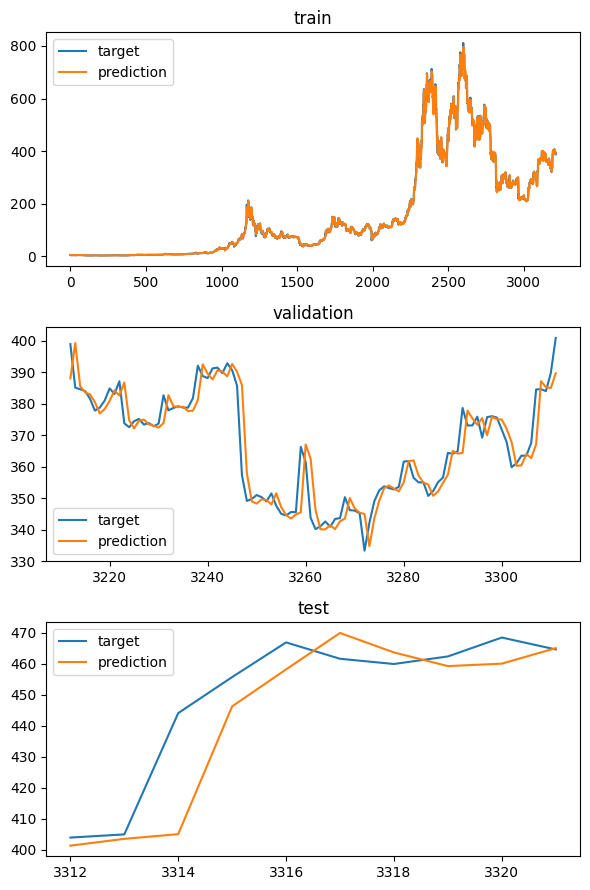

In [ ]:
if __name__ == "__main__":
  args_str = ""
  args_list = args_str.split()

  parser = get_parser()
  args = parser.parse_args(args_list)
  main(args)


##### run - 번외 (다음 날의 close feature을 next_open으로 추가 후)

MODEL FILE: /content/checkpoints/lstm_regression_btc_krw_checkpoint_latest.pt
[TEST DATA]
 0: 404.31 <--> 404.00 (Loss:          0.31)
 1: 461.74 <--> 462.33 (Loss:          0.59)
 2: 441.81 <--> 444.08 (Loss:          2.27)
 3: 459.40 <--> 459.89 (Loss:          0.49)
 4: 468.29 <--> 468.41 (Loss:          0.12)
 5: 457.08 <--> 455.68 (Loss:          1.40)
 6: 465.31 <--> 464.58 (Loss:          0.73)
 7: 467.83 <--> 466.85 (Loss:          0.98)
 8: 405.34 <--> 405.02 (Loss:          0.33)
 9: 462.51 <--> 461.57 (Loss:          0.94)


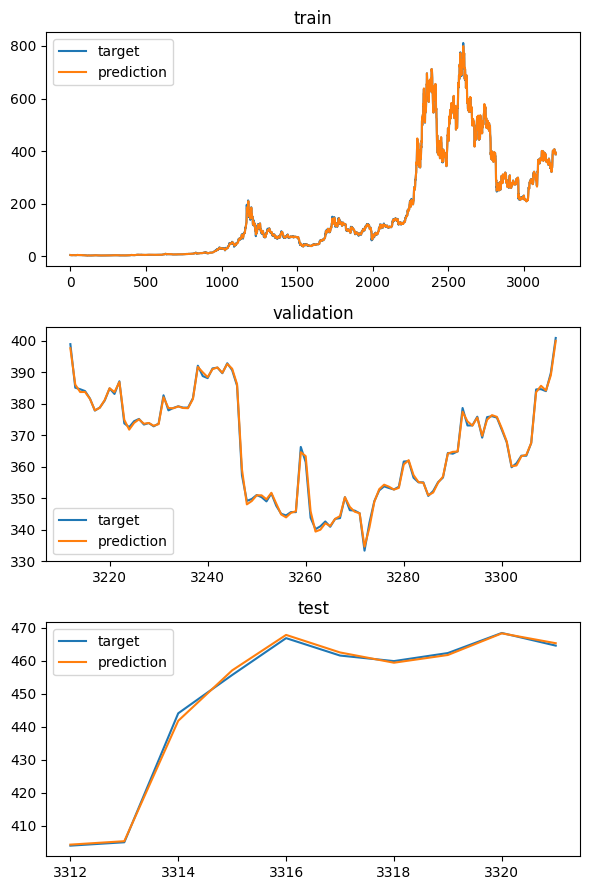

In [ ]:
if __name__ == "__main__":
  args_str = ""
  args_list = args_str.split()

  parser = get_parser()
  args = parser.parse_args(args_list)
  main(args)


### _01_code/_11_lstm_and_its_application/i_crypto_currency_classification_train_lstm.py

##### get_crytocurrency_data

In [17]:
import os
import torch
import pandas as pd

def get_cryptocurrency_data(
    sequence_size=15, validation_size=150, test_size=30, target_column='Close', y_normalizer=1.0e7, is_regression=False
):
    # 현재 디렉터리를 BASE_PATH로 설정
    BASE_PATH = os.getcwd()
    btc_krw_path = os.path.join(BASE_PATH, "BTC_KRW.csv")  # 파일 경로 설정
    
    # 파일 존재 확인
    if not os.path.exists(btc_krw_path):
        raise FileNotFoundError(f"File not found: {btc_krw_path}")
    
    # 데이터 로드
    df = pd.read_csv(btc_krw_path)
    
    # 데이터 타입 확인 및 변환
    for col in df.columns:
        # 문자열 데이터를 숫자로 변환 시도
        if df[col].dtype == 'object':
            try:
                df[col] = pd.to_numeric(df[col], errors='coerce')
            except Exception as e:
                raise ValueError(f"Column {col} contains invalid data: {e}")
    
    # 결측치 확인 및 처리
    if df.isnull().values.any():
        print("Data contains missing values. Filling missing values with 0.")
        df = df.fillna(0)  # 결측치를 0으로 채움

    # 데이터프레임에 음수 값이 있는지 확인
    if (df.select_dtypes(include=['number']) < 0).any().any():
        raise ValueError("Data contains invalid (negative) values.")

    # 데이터 처리
    date_list = df['Date']
    df = df.drop(columns=['Date'])

    row_size = len(df)
    total_size = row_size - sequence_size
    train_size = total_size - (validation_size + test_size)
    if train_size <= 0:
        raise ValueError("Train, validation, and test sizes exceed the available data.")

    #################################################################################################

    row_cursor = 0

    # Train 데이터 생성
    X_train_list, y_train_regression_list, y_train_classification_list, y_train_date = [], [], [], []
    for idx in range(0, train_size):
        sequence_data = df.iloc[idx: idx + sequence_size].values
        X_train_list.append(torch.from_numpy(sequence_data))
        y_train_regression_list.append(df.iloc[idx + sequence_size][target_column])
        y_train_classification_list.append(
            1 if df.iloc[idx + sequence_size][target_column] >= df.iloc[idx + sequence_size - 1][target_column] else 0
        )
        y_train_date.append(date_list[idx + sequence_size])
        row_cursor += 1

    X_train = torch.stack(X_train_list, dim=0).to(torch.float)
    y_train_regression = torch.tensor(y_train_regression_list, dtype=torch.float32) / y_normalizer
    y_train_classification = torch.tensor(y_train_classification_list, dtype=torch.int64)

    # Normalize X_train
    m = X_train.mean(dim=0, keepdim=True)
    s = X_train.std(dim=0, unbiased=False, keepdim=True)
    X_train = (X_train - m) / s

    #################################################################################################

    # Validation 데이터 생성
    X_validation_list, y_validation_regression_list, y_validation_classification_list, y_validation_date = [], [], [], []
    for idx in range(row_cursor, row_cursor + validation_size):
        sequence_data = df.iloc[idx: idx + sequence_size].values
        X_validation_list.append(torch.from_numpy(sequence_data))
        y_validation_regression_list.append(df.iloc[idx + sequence_size][target_column])
        y_validation_classification_list.append(
            1 if df.iloc[idx + sequence_size][target_column] >= df.iloc[idx + sequence_size - 1][target_column] else 0
        )
        y_validation_date.append(date_list[idx + sequence_size])
        row_cursor += 1

    X_validation = torch.stack(X_validation_list, dim=0).to(torch.float)
    y_validation_regression = torch.tensor(y_validation_regression_list, dtype=torch.float32) / y_normalizer
    y_validation_classification = torch.tensor(y_validation_classification_list, dtype=torch.int64)

    X_validation = (X_validation - m) / s

    #################################################################################################

    # Test 데이터 생성
    X_test_list, y_test_regression_list, y_test_classification_list, y_test_date = [], [], [], []
    for idx in range(row_cursor, row_cursor + test_size):
        sequence_data = df.iloc[idx: idx + sequence_size].values
        X_test_list.append(torch.from_numpy(sequence_data))
        y_test_regression_list.append(df.iloc[idx + sequence_size][target_column])
        y_test_classification_list.append(
            1 if df.iloc[idx + sequence_size][target_column] > df.iloc[idx + sequence_size - 1][target_column] else 0
        )
        y_test_date.append(date_list[idx + sequence_size])
        row_cursor += 1

    X_test = torch.stack(X_test_list, dim=0).to(torch.float)
    y_test_regression = torch.tensor(y_test_regression_list, dtype=torch.float32) / y_normalizer
    y_test_classification = torch.tensor(y_test_classification_list, dtype=torch.int64)

    X_test = (X_test - m) / s

    # Regression or Classification 데이터 반환
    if is_regression:
        return (
            X_train, X_validation, X_test,
            y_train_regression, y_validation_regression, y_test_regression,
            y_train_date, y_validation_date, y_test_date
        )
    else:
        return (
            X_train, X_validation, X_test,
            y_train_classification, y_validation_classification, y_test_classification,
            y_train_date, y_validation_date, y_test_date
        )


##### get_btc_krw_data

In [18]:
def get_btc_krw_data(sequence_size=15, validation_size=150, test_size=30, is_regression=False):
  X_train, X_validation, X_test, y_train, y_validation, y_test, y_train_date, y_validation_date, y_test_date \
    = get_cryptocurrency_data(
      sequence_size=sequence_size, validation_size=validation_size, test_size=test_size,
      target_column='Close', y_normalizer=1.0e7, is_regression=is_regression
  )

  train_crypto_currency_dataset = CryptoCurrencyDataset(X=X_train, y=y_train)
  validation_crypto_currency_dataset = CryptoCurrencyDataset(X=X_validation, y=y_validation)
  test_crypto_currency_dataset = CryptoCurrencyDataset(X=X_test, y=y_test)

  train_data_loader = DataLoader(
    dataset=train_crypto_currency_dataset, batch_size=wandb.config.batch_size, shuffle=True
  )
  validation_data_loader = DataLoader(
    dataset=validation_crypto_currency_dataset, batch_size=wandb.config.batch_size, shuffle=True
  )
  test_data_loader = DataLoader(
    dataset=test_crypto_currency_dataset, batch_size=len(test_crypto_currency_dataset), shuffle=True
  )

  return train_data_loader, validation_data_loader, test_data_loader

##### ClassificationTrainer

In [19]:
class ClassificationTrainer:
  def __init__(
    self, project_name, model, optimizer, train_data_loader, validation_data_loader, transforms,
    run_time_str, wandb, device, checkpoint_file_path
  ):
    self.project_name = project_name
    self.model = model
    self.optimizer = optimizer
    self.train_data_loader = train_data_loader
    self.validation_data_loader = validation_data_loader
    self.transforms = transforms
    self.run_time_str = run_time_str
    self.wandb = wandb
    self.device = device
    self.checkpoint_file_path = checkpoint_file_path

    # Use a built-in loss function
    self.loss_fn = nn.CrossEntropyLoss()

  def do_train(self):
    self.model.train()  # Explained at 'Diverse Techniques' section

    loss_train = 0.0
    num_corrects_train = 0
    num_trained_samples = 0
    num_trains = 0

    for train_batch in self.train_data_loader:
      input_train, target_train = train_batch
      input_train = input_train.to(device=self.device)
      target_train = target_train.to(device=self.device)

      if self.transforms:
        input_train = self.transforms(input_train)

      output_train = self.model(input_train)

      loss = self.loss_fn(output_train, target_train)
      loss_train += loss.item()

      predicted_train = torch.argmax(output_train, dim=1)
      num_corrects_train += torch.sum(torch.eq(predicted_train, target_train)).item()

      num_trained_samples += len(input_train)
      num_trains += 1

      self.optimizer.zero_grad()
      loss.backward()
      self.optimizer.step()

    train_loss = loss_train / num_trains
    train_accuracy = 100.0 * num_corrects_train / num_trained_samples

    return train_loss, train_accuracy

  def do_validation(self):
    self.model.eval()   # Explained at 'Diverse Techniques' section

    loss_validation = 0.0
    num_corrects_validation = 0
    num_validated_samples = 0
    num_validations = 0

    with torch.no_grad():
      for validation_batch in self.validation_data_loader:
        input_validation, target_validation = validation_batch
        input_validation = input_validation.to(device=self.device)
        target_validation = target_validation.to(device=self.device)

        if self.transforms:
          input_validation = self.transforms(input_validation)

        output_validation = self.model(input_validation)
        loss_validation += self.loss_fn(output_validation, target_validation).item()

        predicted_validation = torch.argmax(output_validation, dim=1)
        num_corrects_validation += torch.sum(torch.eq(predicted_validation, target_validation)).item()

        num_validated_samples += len(input_validation)
        num_validations += 1

    validation_loss = loss_validation / num_validations
    validation_accuracy = 100.0 * num_corrects_validation / num_validated_samples

    return validation_loss, validation_accuracy

  def train_loop(self):
    early_stopping = EarlyStopping(
      patience=self.wandb.config.early_stop_patience,
      delta=self.wandb.config.early_stop_delta,
      project_name=self.project_name,
      checkpoint_file_path=self.checkpoint_file_path,
      run_time_str=self.run_time_str
    )
    n_epochs = self.wandb.config.epochs
    training_start_time = datetime.now()

    for epoch in range(1, n_epochs + 1):
      train_loss, train_accuracy = self.do_train()

      if epoch == 1 or epoch % self.wandb.config.validation_intervals == 0:
        validation_loss, validation_accuracy = self.do_validation()

        elapsed_time = datetime.now() - training_start_time
        epoch_per_second = 0 if elapsed_time.seconds == 0 else epoch / elapsed_time.seconds

        message, early_stop = early_stopping.check_and_save(validation_loss, self.model)

        print(
          f"[Epoch {epoch:>3}] "
          f"T_loss: {train_loss:7.5f}, "
          f"T_accuracy: {train_accuracy:6.4f} | "
          f"V_loss: {validation_loss:7.5f}, "
          f"V_accuracy: {validation_accuracy:6.4f} | "
          f"{message} | "
          f"T_time: {strfdelta(elapsed_time, '%H:%M:%S')}, "
          f"T_speed: {epoch_per_second:4.3f}"
        )

        self.wandb.log({
          "Epoch": epoch,
          "Training loss": train_loss,
          "Training accuracy (%)": train_accuracy,
          "Validation loss": validation_loss,
          "Validation accuracy (%)": validation_accuracy,
          "Training speed (epochs/sec.)": epoch_per_second,
        })

        if early_stop:
          break

    elapsed_time = datetime.now() - training_start_time
    print(f"Final training time: {strfdelta(elapsed_time, '%H:%M:%S')}")


##### get_model

In [20]:
def get_model():
    class MyModel(nn.Module):
        def __init__(self, n_input, n_output):
            super().__init__()

            # LSTM layer 
            self.lstm = nn.LSTM(input_size=5, hidden_size=128, num_layers=2, batch_first=True, dropout=0.0)

            # Fully Connected Layer 
            self.fcn = nn.Linear(in_features=128, out_features=n_output)

        def forward(self, x):
            x, hidden = self.lstm(x)
            x = x[:, -1, :]  # 마지막 hidden state 사용
            x = self.fcn(x)
            return x

   
    my_model = MyModel(n_input=5, n_output=2)

    return my_model


##### main

In [21]:
def main(args):
  run_time_str = datetime.now().astimezone().strftime('%Y-%m-%d_%H-%M-%S')

  config = {
    'epochs': args.epochs,
    'batch_size': args.batch_size,
    'validation_intervals': args.validation_intervals,
    'learning_rate': args.learning_rate,
    'early_stop_patience': args.early_stop_patience,
    'early_stop_delta': args.early_stop_delta,
    'weight_decay': args.weight_decay
  }

  project_name = "lstm_classification_btc_krw"
  wandb.init(
    mode="online" if args.wandb else "disabled",
    project=project_name,
    notes="btc_krw experiment with lstm",
    tags=["lstm", "classification", "btc_krw"],
    name=run_time_str,
    config=config
  )
  print(args)
  print(wandb.config)

  train_data_loader, validation_data_loader, _ = get_btc_krw_data(is_regression=False)
  device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
  print(f"Training on device {device}.")

  model = get_model()
  model.to(device)
  wandb.watch(model)

  optimizer = optim.Adam(model.parameters(), lr=wandb.config.learning_rate, weight_decay=wandb.config.weight_decay)

  classification_trainer = ClassificationTrainer(
    project_name, model, optimizer, train_data_loader, validation_data_loader, None,
    run_time_str, wandb, device, CHECKPOINT_FILE_PATH
  )
  classification_trainer.train_loop()

  wandb.finish()


##### run - featrue 추가 전

In [22]:
if __name__ == "__main__":
  # 변경3 weight decay (-w)
  args_str = "--wandb -p 100 -r 0.00001 -w 0.00001"
  args_list = args_str.split()

  parser = get_parser()
  args = parser.parse_args(args_list)
  main(args)

  # python _01_code/_11_lstm_and_its_application/i_crypto_currency_classification_train_lstm.py -p 100 -r 0.00001

/usr/local/lib/python3.10/dist-packages/pydantic/main.py:314: UserWarning: Pydantic serializer warnings:
  Expected `list[str]` but got `tuple` - serialized value may not be as expected
  return self.__pydantic_serializer__.to_python(


Namespace(wandb=True, batch_size=2048, epochs=10000, learning_rate=1e-05, weight_decay=1e-05, validation_intervals=30, early_stop_patience=100, early_stop_delta=1e-06)
{'epochs': 10000, 'batch_size': 2048, 'validation_intervals': 30, 'learning_rate': 1e-05, 'early_stop_patience': 100, 'early_stop_delta': 1e-06, 'weight_decay': 1e-05}
Data contains missing values. Filling missing values with 0.
Training on device cuda:0.
[Epoch   1] T_loss: 0.69364, T_accuracy: 47.3252 | V_loss: 0.69315, V_accuracy: 52.6667 | Early stopping is stated! | T_time: 00:00:00, T_speed: 0.000
[Epoch  30] T_loss: 0.69260, T_accuracy: 52.5899 | V_loss: 0.69320, V_accuracy: 52.0000 | Early stopping counter: 1 out of 100 | T_time: 00:00:01, T_speed: 30.000
[Epoch  60] T_loss: 0.69176, T_accuracy: 53.2692 | V_loss: 0.69335, V_accuracy: 44.6667 | Early stopping counter: 2 out of 100 | T_time: 00:00:02, T_speed: 30.000
[Epoch  90] T_loss: 0.69139, T_accuracy: 53.4390 | V_loss: 0.69358, V_accuracy: 47.3333 | Early sto

[Epoch 1440] T_loss: 0.69026, T_accuracy: 53.2126 | V_loss: 0.69391, V_accuracy: 47.3333 | Early stopping counter: 48 out of 100 | T_time: 00:01:06, T_speed: 21.818
[Epoch 1470] T_loss: 0.69072, T_accuracy: 53.2126 | V_loss: 0.69398, V_accuracy: 47.3333 | Early stopping counter: 49 out of 100 | T_time: 00:01:07, T_speed: 21.940
[Epoch 1500] T_loss: 0.69076, T_accuracy: 53.1560 | V_loss: 0.69400, V_accuracy: 47.3333 | Early stopping counter: 50 out of 100 | T_time: 00:01:09, T_speed: 21.739
[Epoch 1530] T_loss: 0.69050, T_accuracy: 53.2126 | V_loss: 0.69401, V_accuracy: 47.3333 | Early stopping counter: 51 out of 100 | T_time: 00:01:10, T_speed: 21.857
[Epoch 1560] T_loss: 0.69032, T_accuracy: 53.2126 | V_loss: 0.69390, V_accuracy: 47.3333 | Early stopping counter: 52 out of 100 | T_time: 00:01:11, T_speed: 21.972
[Epoch 1590] T_loss: 0.69068, T_accuracy: 53.2126 | V_loss: 0.69393, V_accuracy: 47.3333 | Early stopping counter: 53 out of 100 | T_time: 00:01:13, T_speed: 21.781
[Epoch 162

[Epoch 2940] T_loss: 0.69035, T_accuracy: 53.2975 | V_loss: 0.69367, V_accuracy: 47.3333 | Early stopping counter: 98 out of 100 | T_time: 00:02:14, T_speed: 21.940
[Epoch 2970] T_loss: 0.69064, T_accuracy: 53.3258 | V_loss: 0.69369, V_accuracy: 47.3333 | Early stopping counter: 99 out of 100 | T_time: 00:02:15, T_speed: 22.000
[Epoch 3000] T_loss: 0.69055, T_accuracy: 53.3824 | V_loss: 0.69381, V_accuracy: 47.3333 | Early stopping counter: 100 out of 100 *** TRAIN EARLY STOPPED! *** | T_time: 00:02:17, T_speed: 21.898
Final training time: 00:02:17


Epoch,▁▁▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇████
Training accuracy (%),▆▂▃▄▃▁▂▃▃▃▄▅▃▃▃▄▄▄▄▅▆▃▅▆▆▄▆█▆▇██▇▆▆▅▇▆▆▇
Training loss,█▆▄▄▃▂▃▄▃▁▂▂▂▃▂▁▃▂▂▂▂▁▄▄▄▂▁▂▃▄▂▃▃▂▂▁▂▃▂▃
Training speed (epochs/sec.),█▄▂▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Validation accuracy (%),█▇▁▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃
Validation loss,▁▆███▇▇▇▆▆▆▆▆▆▆▅▆▅▆▆▆▅▆▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▄
Epoch,3000
Training accuracy (%),53.38239
Training loss,0.69055
Training speed (epochs/sec.),21.89781
Validation accuracy (%),47.33333


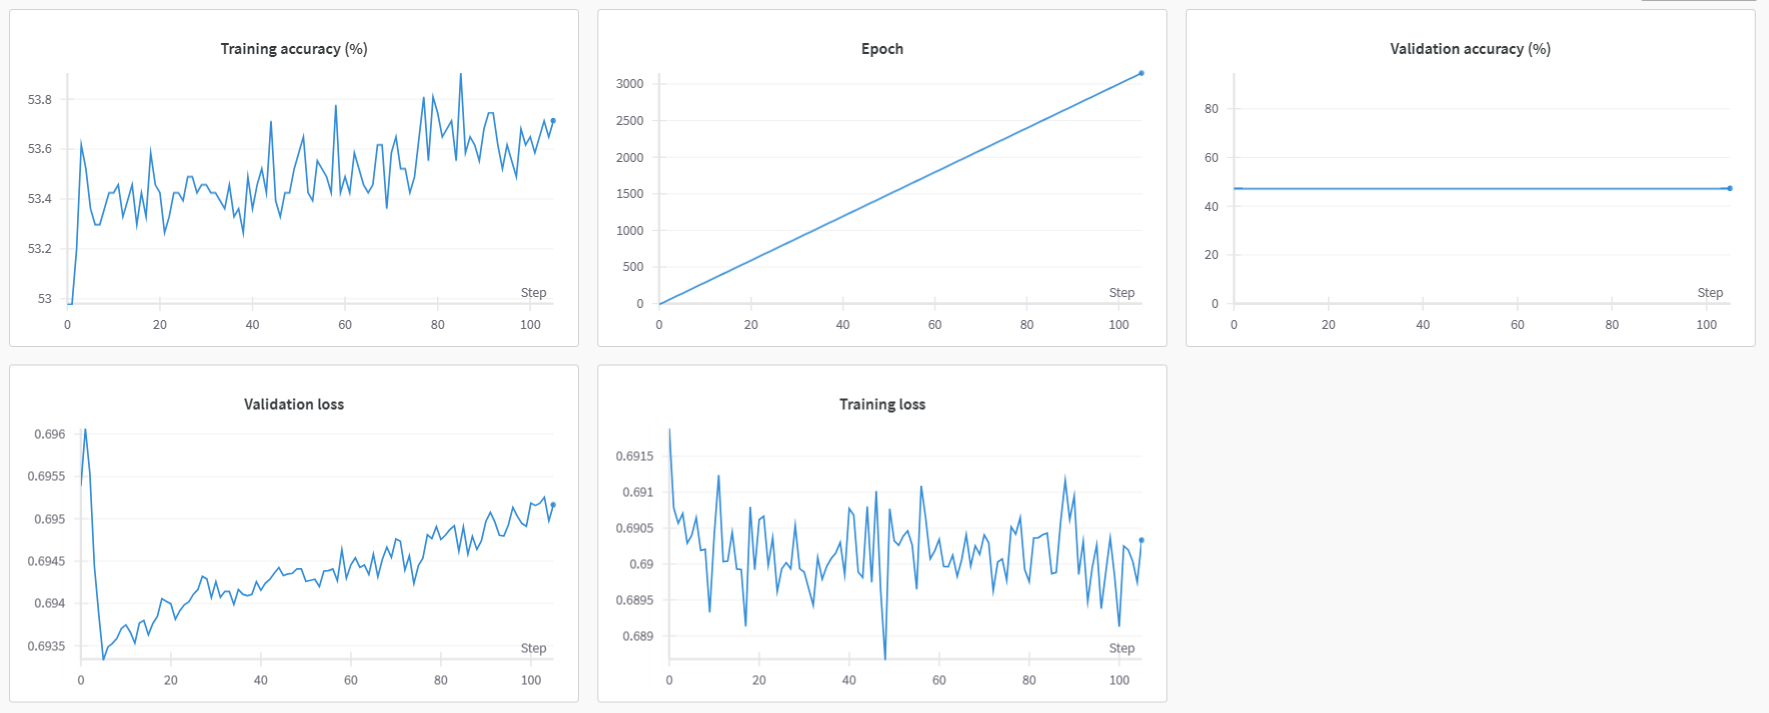

In [ ]:
#![이미지](https://drive.google.com/file/d/1esF9ZTx0CSNI-8AAirwPXfNQWjnyIIYR/view?usp=drive_link)

from IPython.display import Image
BASE_PATH = "/content/drive/MyDrive/DeepLeaning/"
img = os.path.join(BASE_PATH , "21.PNG")
Image(img)

##### run - featrue 추가 후

In [23]:
if __name__ == "__main__":
  # 변경3 weight decay (-w)
  args_str = "--wandb -p 100 -r 0.00001 -w 0.00001"
  args_list = args_str.split()

  parser = get_parser()
  args = parser.parse_args(args_list)
  main(args)

  # python _01_code/_11_lstm_and_its_application/i_crypto_currency_classification_train_lstm.py -p 100 -r 0.00001

/usr/local/lib/python3.10/dist-packages/pydantic/main.py:314: UserWarning: Pydantic serializer warnings:
  Expected `list[str]` but got `tuple` - serialized value may not be as expected
  return self.__pydantic_serializer__.to_python(


Namespace(wandb=True, batch_size=2048, epochs=10000, learning_rate=1e-05, weight_decay=1e-05, validation_intervals=30, early_stop_patience=100, early_stop_delta=1e-06)
{'epochs': 10000, 'batch_size': 2048, 'validation_intervals': 30, 'learning_rate': 1e-05, 'early_stop_patience': 100, 'early_stop_delta': 1e-06, 'weight_decay': 1e-05}
Data contains missing values. Filling missing values with 0.
Training on device cuda:0.
[Epoch   1] T_loss: 0.69132, T_accuracy: 52.9295 | V_loss: 0.69228, V_accuracy: 52.6667 | Early stopping is stated! | T_time: 00:00:00, T_speed: 0.000
[Epoch  30] T_loss: 0.69097, T_accuracy: 52.9295 | V_loss: 0.69175, V_accuracy: 52.6667 | V_loss decreased (0.69228 --> 0.69175). Saving model... | T_time: 00:00:01, T_speed: 30.000
[Epoch  60] T_loss: 0.69101, T_accuracy: 52.9295 | V_loss: 0.69231, V_accuracy: 52.6667 | Early stopping counter: 1 out of 100 | T_time: 00:00:02, T_speed: 30.000
[Epoch  90] T_loss: 0.69054, T_accuracy: 53.0710 | V_loss: 0.69324, V_accuracy: 

[Epoch 1440] T_loss: 0.69031, T_accuracy: 53.2409 | V_loss: 0.69386, V_accuracy: 46.0000 | Early stopping counter: 47 out of 100 | T_time: 00:01:04, T_speed: 22.500
[Epoch 1470] T_loss: 0.69043, T_accuracy: 53.2692 | V_loss: 0.69387, V_accuracy: 46.0000 | Early stopping counter: 48 out of 100 | T_time: 00:01:06, T_speed: 22.273
[Epoch 1500] T_loss: 0.69032, T_accuracy: 53.2692 | V_loss: 0.69383, V_accuracy: 46.0000 | Early stopping counter: 49 out of 100 | T_time: 00:01:07, T_speed: 22.388
[Epoch 1530] T_loss: 0.69060, T_accuracy: 53.2692 | V_loss: 0.69386, V_accuracy: 46.0000 | Early stopping counter: 50 out of 100 | T_time: 00:01:08, T_speed: 22.500
[Epoch 1560] T_loss: 0.69072, T_accuracy: 53.2975 | V_loss: 0.69395, V_accuracy: 47.3333 | Early stopping counter: 51 out of 100 | T_time: 00:01:10, T_speed: 22.286
[Epoch 1590] T_loss: 0.69026, T_accuracy: 53.2975 | V_loss: 0.69386, V_accuracy: 46.0000 | Early stopping counter: 52 out of 100 | T_time: 00:01:11, T_speed: 22.394
[Epoch 162

[Epoch 2940] T_loss: 0.69024, T_accuracy: 53.2409 | V_loss: 0.69367, V_accuracy: 47.3333 | Early stopping counter: 97 out of 100 | T_time: 00:02:13, T_speed: 22.105
[Epoch 2970] T_loss: 0.69049, T_accuracy: 53.3258 | V_loss: 0.69365, V_accuracy: 47.3333 | Early stopping counter: 98 out of 100 | T_time: 00:02:14, T_speed: 22.164
[Epoch 3000] T_loss: 0.69055, T_accuracy: 53.2975 | V_loss: 0.69362, V_accuracy: 47.3333 | Early stopping counter: 99 out of 100 | T_time: 00:02:15, T_speed: 22.222
[Epoch 3030] T_loss: 0.69052, T_accuracy: 53.4107 | V_loss: 0.69376, V_accuracy: 47.3333 | Early stopping counter: 100 out of 100 *** TRAIN EARLY STOPPED! *** | T_time: 00:02:17, T_speed: 22.117
Final training time: 00:02:17


Epoch,▁▁▁▁▁▂▂▂▂▂▃▃▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇██
Training accuracy (%),▁▄▃▅▃▃▄▄▄▄▆▅▅▅▄▄▄▆▇▇▆▆▆▇▇███▇▇▆▇▆██▇▇█▆▇
Training loss,█▆▂▂▂▅▃▄▂▃▄▄▃▂▂▂▂▃▄▃▃▄▃▂▃▂▄▃▁▂▅▂▂▃▄▃▃▄▄▃
Training speed (epochs/sec.),█▁▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂
Validation accuracy (%),██▃▃▃▃▃▃▃▃▃▃▃▂▂▂▃▂▁▂▃▂▂▂▄▂▂▃▃▂▃▁▂▂▃▃▃▃▃▃
Validation loss,▁▆▇███▇▇▇▇▇▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▅▅▆▅▅▆▆▆▅▅▆▅▅
Epoch,3030
Training accuracy (%),53.4107
Training loss,0.69052
Training speed (epochs/sec.),22.11679
Validation accuracy (%),47.33333


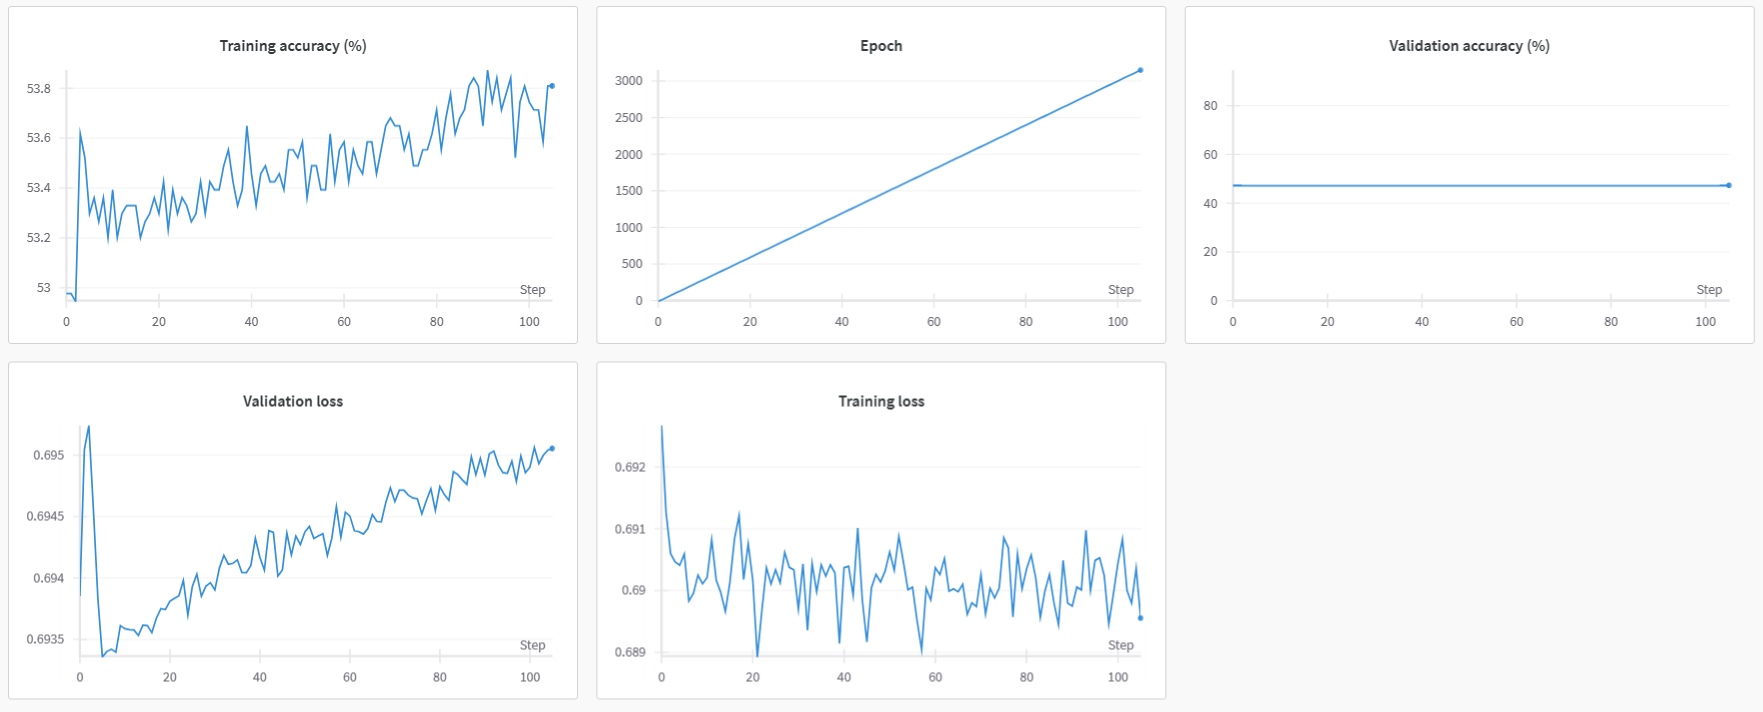

In [ ]:
#![이미지](https://drive.google.com/file/d/1esF9ZTx0CSNI-8AAirwPXfNQWjnyIIYR/view?usp=drive_link)

from IPython.display import Image
BASE_PATH = "/content/drive/MyDrive/DeepLeaning/"
img = os.path.join(BASE_PATH , "22.PNG")
Image(img)

### _01_code/_11_lstm_and_its_application/j_crypto_currency_classification_test_lstm.py

##### test

In [ ]:
def test(test_model):
  _, _, test_data_loader = get_btc_krw_data(is_regression=False)

  test_model.eval()

  num_corrects_test = 0
  num_tested_samples = 0

  print("[TEST DATA]")
  with torch.no_grad():
    for test_batch in test_data_loader:
      input_test, target_test = test_batch

      output_test = test_model(input_test)

      predicted_test = torch.argmax(output_test, dim=1)
      num_corrects_test += torch.sum(torch.eq(predicted_test, target_test))

      num_tested_samples += len(input_test)

    test_accuracy = 100.0 * num_corrects_test / num_tested_samples

    print(f"TEST RESULTS: {test_accuracy:6.3f}%")

    for idx, (output, target) in enumerate(zip(output_test, target_test)):
      print("{0:2}: {1:6,.2f} <--> {2:6,.2f}".format(
        idx, torch.argmax(output).item(), target.item()
      ))


##### main

In [ ]:
def main(args):
  run_time_str = datetime.now().astimezone().strftime('%Y-%m-%d_%H-%M-%S')

  config = {
    'epochs': args.epochs,
    'batch_size': args.batch_size,
    'validation_intervals': args.validation_intervals,
    'learning_rate': args.learning_rate,
    'early_stop_patience': args.early_stop_patience,
    'early_stop_delta': args.early_stop_delta,
  }

  project_name = "lstm_classification_btc_krw"
  wandb.init(
    mode="disabled",
    project=project_name,
    notes="btc_krw experiment with lstm",
    tags=["lstm", "regression", "btc_krw"],
    name=run_time_str,
    config=config
  )

  test_model = get_model()

  latest_file_path = os.path.join(
    CHECKPOINT_FILE_PATH, f"{project_name}_checkpoint_latest.pt"
  )
  print("MODEL FILE: {0}".format(latest_file_path))
  test_model.load_state_dict(torch.load(latest_file_path, map_location=torch.device('cpu')))

  test(test_model)

##### run - feature 추가 전

In [ ]:
if __name__ == "__main__":
  args_str = ""
  args_list = args_str.split()

  parser = get_parser()
  args = parser.parse_args(args_list)
  main(args)

MODEL FILE: /content/checkpoints/lstm_classification_btc_krw_checkpoint_latest.pt
[TEST DATA]
TEST RESULTS: 66.667%
 0:   1.00 <-->   1.00
 1:   1.00 <-->   1.00
 2:   1.00 <-->   0.00
 3:   0.00 <-->   1.00
 4:   1.00 <-->   1.00
 5:   1.00 <-->   0.00
 6:   1.00 <-->   0.00
 7:   1.00 <-->   1.00
 8:   1.00 <-->   0.00
 9:   0.00 <-->   1.00
10:   1.00 <-->   0.00
11:   1.00 <-->   0.00
12:   1.00 <-->   1.00
13:   1.00 <-->   0.00
14:   0.00 <-->   0.00
15:   1.00 <-->   1.00
16:   1.00 <-->   1.00
17:   1.00 <-->   1.00
18:   1.00 <-->   1.00
19:   1.00 <-->   1.00
20:   1.00 <-->   1.00
21:   0.00 <-->   0.00
22:   1.00 <-->   0.00
23:   1.00 <-->   1.00
24:   1.00 <-->   1.00
25:   1.00 <-->   1.00
26:   1.00 <-->   1.00
27:   0.00 <-->   0.00
28:   1.00 <-->   1.00
29:   1.00 <-->   1.00


#### run - feature 추가 후

In [ ]:
if __name__ == "__main__":
  args_str = ""
  args_list = args_str.split()

  parser = get_parser()
  args = parser.parse_args(args_list)
  main(args)

MODEL FILE: /content/checkpoints/lstm_classification_btc_krw_checkpoint_latest.pt
[TEST DATA]
TEST RESULTS: 66.667%
 0:   1.00 <-->   1.00
 1:   1.00 <-->   1.00
 2:   1.00 <-->   1.00
 3:   1.00 <-->   0.00
 4:   1.00 <-->   0.00
 5:   1.00 <-->   1.00
 6:   1.00 <-->   1.00
 7:   1.00 <-->   0.00
 8:   1.00 <-->   1.00
 9:   1.00 <-->   1.00
10:   0.00 <-->   0.00
11:   1.00 <-->   1.00
12:   1.00 <-->   1.00
13:   1.00 <-->   1.00
14:   1.00 <-->   0.00
15:   1.00 <-->   1.00
16:   1.00 <-->   1.00
17:   1.00 <-->   1.00
18:   1.00 <-->   0.00
19:   0.00 <-->   1.00
20:   1.00 <-->   1.00
21:   0.00 <-->   0.00
22:   0.00 <-->   0.00
23:   1.00 <-->   0.00
24:   1.00 <-->   1.00
25:   1.00 <-->   0.00
26:   1.00 <-->   1.00
27:   1.00 <-->   0.00
28:   1.00 <-->   1.00
29:   0.00 <-->   1.00


##### run2

In [ ]:
if __name__ == "__main__":
  args_str = ""
  args_list = args_str.split()

  parser = get_parser()
  args = parser.parse_args(args_list)
  main(args)

MODEL FILE: /content/checkpoints/lstm_classification_btc_krw_checkpoint_latest.pt
[TEST DATA]
TEST RESULTS: 70.000%
 0:   1.00 <-->   0.00
 1:   1.00 <-->   0.00
 2:   1.00 <-->   0.00
 3:   1.00 <-->   1.00
 4:   1.00 <-->   1.00
 5:   1.00 <-->   1.00
 6:   1.00 <-->   1.00
 7:   1.00 <-->   1.00
 8:   1.00 <-->   1.00
 9:   1.00 <-->   1.00


## 숙제 후기

이번 실습에서는 데이터를 활용해 새로운 Feature를 추가하고, 이를 통해 성능 변화를 확인해보는 경험을 했다. 내가 추가한 Feature는 Next_Open으로, 해당 일자의 다음 날 Open 가격을 의미한다. Next_Open은 해당 일자의 Close 가격과 직접적으로 연관된 정보이기 때문에, 이를 추가하면 Close 예측 성능에 어느 정도 긍정적인 영향을 줄 것으로 기대했다.

실습 과정에서 새로운 Feature가 포함된 CSV 파일을 생성하기 위해 별도의 코드를 작성했다. 이후, 생성한 데이터를 학습 및 테스트에 사용해 Classification과 Regression 두 가지 경우의 성능 변화를 관찰했다.

결과적으로, Next_Open을 추가했을 때 Classification과 Regression 모두에서 성능 변화는 크지 않았다. 반면, 번외 실험으로 Next_Open 대신 Close Feature를 추가했을 때는 예상외의 성능 향상이 있었다. 이를 통해, 다양한 Feature를 실험적으로 추가해보는 것이 성능 개선에 얼마나 중요한지 알게 되었다.

한편, 실습 중 새로운 CSV 파일을 생성할 때 인덱스 열을 제거하지 않아, 불필요한 Feature가 추가되는 실수가 있었다. 이로 인해 Feature가 2개 추가되었음에도 이를 1개로 잘못 인식해 코드에 오류가 발생했고, 이를 수정하는 데 시간이 걸렸다. 이 경험을 통해 데이터를 전처리할 때 인덱스 열을 반드시 제거하는 방법과 데이터 구조를 면밀히 확인하는 습관을 배울 수 있었다.

이전까지는 성능 개선을 위해 모델 구조나 하이퍼파라미터 조정을 떠올렸지만, 이번 실습을 통해 Feature 엔지니어링이 모델 성능 개선에 중요한 영향을 미칠 수 있음을 직접 확인할 수 있었다. 앞으로도 데이터를 활용한 다양한 접근법을 시도해보고자 한다.